# LightGBM model

### Read data

In [1]:
import lightgbm as lgbm
from scipy import sparse as ssp
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [2]:
path = "./data/"

train = pd.read_csv(path+'train.csv')
train_label = train['target']
train_id = train['id']
test = pd.read_csv(path+'test.csv')
test_id = test['id']

In [3]:
train

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595207,1488013,0,3,1,10,0,0,0,0,0,...,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,...,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,...,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,...,4,1,4,2,0,1,1,1,0,0


In [4]:
train_label.value_counts()/train_label.count()

0    0.963552
1    0.036448
Name: target, dtype: float64

## Khám phá dữ liệu

In [5]:
y = train['target'].values
drop_feature = [
    'id',
    'target'
]

X = train.drop(drop_feature,axis=1)
feature_names = X.columns.tolist()
cat_features = [c for c in feature_names if ('cat' in c and 'count' not in c)]
num_features = [c for c in feature_names if ('cat' not in c and 'calc' not in c)]

cat_features là các đặc trưng categorical..
fddfdf

In [6]:
num_features

['ps_ind_01',
 'ps_ind_03',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_14',
 'ps_ind_15',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_11',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15']

In [7]:
X.columns.sort_values()

Index(['ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05',
       'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10',
       'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11', 'ps_car_11_cat', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02',
       'ps_reg_03'],
      dtype='obj

In [8]:
X.columns.str.split("_").str[1].value_counts()

calc    20
ind     18
car     16
reg      3
dtype: int64

In [9]:
missing_col = []
for col in X.columns:
    if -1 in X[col].unique():
        miss_count = (X[col] == -1).sum()
        missing_col.append((col, miss_count))
missing_col.sort(key = lambda x: x[1], reverse=True)
missing_col

[('ps_car_03_cat', 411231),
 ('ps_car_05_cat', 266551),
 ('ps_reg_03', 107772),
 ('ps_car_14', 42620),
 ('ps_car_07_cat', 11489),
 ('ps_ind_05_cat', 5809),
 ('ps_car_09_cat', 569),
 ('ps_ind_02_cat', 216),
 ('ps_car_01_cat', 107),
 ('ps_ind_04_cat', 83),
 ('ps_car_02_cat', 5),
 ('ps_car_11', 5),
 ('ps_car_12', 1)]

In [10]:
train["ps_ind_02_cat"].unique()

array([ 2,  1,  4,  3, -1], dtype=int64)

In [11]:
train[["ps_ind_02_cat", "target"]].groupby("ps_ind_02_cat").sum()

,target
ps_ind_02_cat,
-1,40
1,15428
2,4713
3,1049
4,464


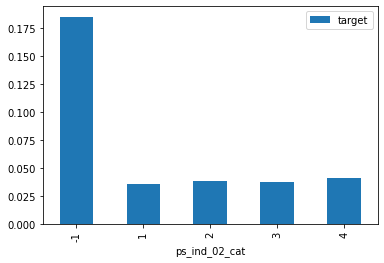

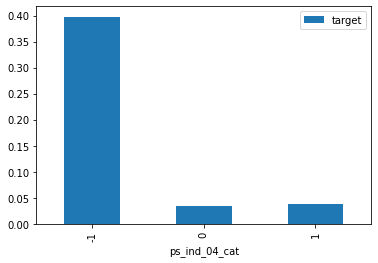

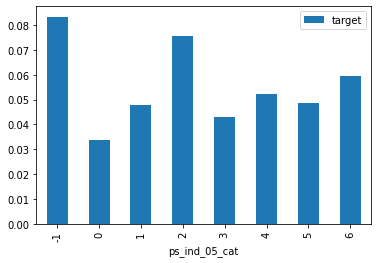

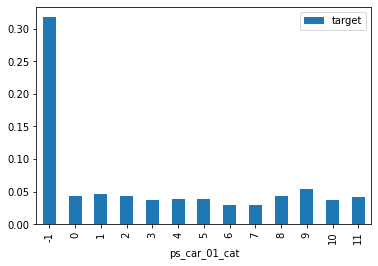

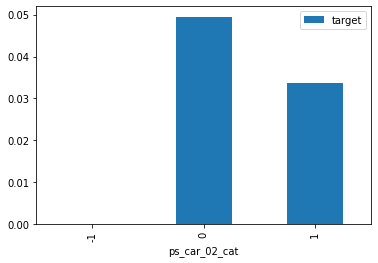

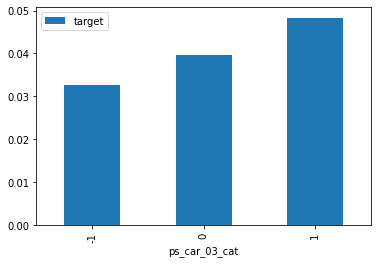

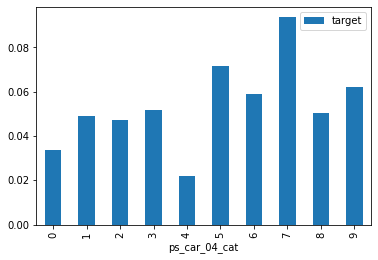

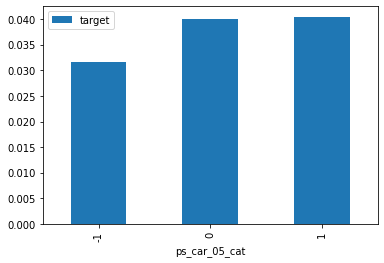

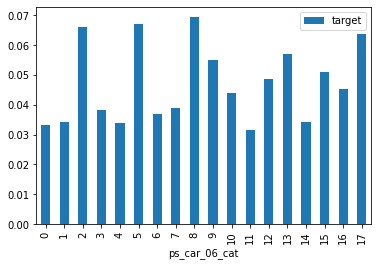

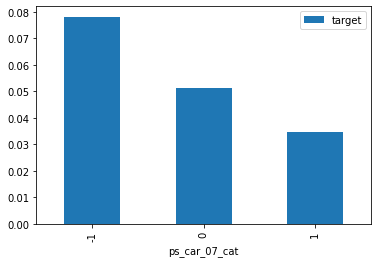

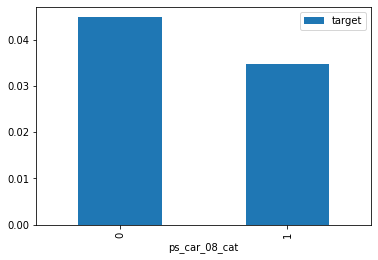

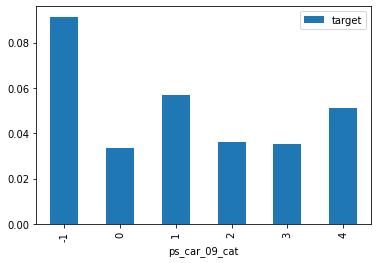

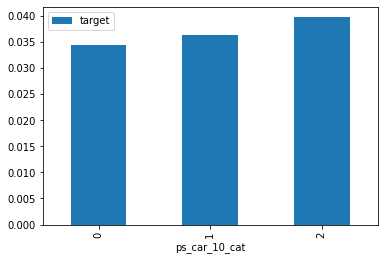

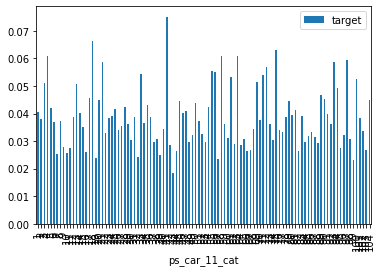

In [12]:
for col in cat_features:
    train[[col, "target"]].groupby(col).mean().plot.bar()
plt.show()

As we can see from the variables **with missing values**, it is a good idea to keep the missing values as a separate category value, instead of replacing them by the mode for instance. The customers with a missing value appear to have a much higher (in some cases much lower) probability to ask for an insurance claim.

## Feature engineer
* Loại bỏ tất cả đặc trưng `calc`
* Thêm đặc trưng: Số lượng giá trị thiếu mỗi dòng
* Mã hóa one hot với các đặc trưng `cat`
* Gộp các đặc trưng `ind` làm một: `new_ind`
* Đếm các đặc trưng `cat` kể cả `new_ind`

### Số lượng giá trị thiếu mỗi dòng

In [13]:
train['missing'] = (train==-1).sum(axis=1).astype(float)
test['missing'] = (test==-1).sum(axis=1).astype(float)
num_features.append('missing')

In [14]:
train["missing"].value_counts()

2.0    254982
1.0    156295
0.0    124931
3.0     56042
4.0      2883
7.0        53
6.0        19
8.0         7
Name: missing, dtype: int64

<AxesSubplot:xlabel='missing'>

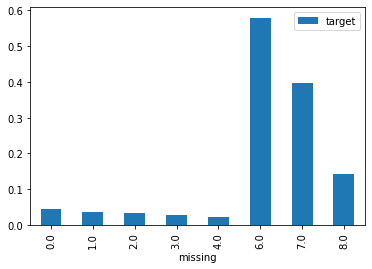

In [15]:
train[["missing", "target"]].groupby("missing").mean().plot.bar()

### Chuyển các đặc trưng categorical sang one hot

In [16]:
for c in cat_features:
    le = LabelEncoder()
    le.fit(train[c])
    train[c] = le.transform(train[c])
    test[c] = le.transform(test[c])

enc = OneHotEncoder()
enc.fit(train[cat_features])
X_cat = enc.transform(train[cat_features])
X_t_cat = enc.transform(test[cat_features])

In [17]:
train[cat_features].describe()

,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.359306,1.416794,1.405188,9.295933,1.829931,0.495101,0.725192,0.842268,6.555340,1.910027,0.832080,2.328890,0.992136,61.215674
std,0.663578,0.493311,1.350642,2.508270,0.375716,0.788654,2.153463,0.844417,5.501445,0.347106,0.373796,0.978747,0.091619,33.012455
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,8.000000,2.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,31.000000
50%,1.000000,1.000000,1.000000,8.000000,2.000000,0.000000,0.000000,1.000000,7.000000,2.000000,1.000000,3.000000,1.000000,64.000000
75%,2.000000,2.000000,1.000000,12.000000,2.000000,1.000000,0.000000,2.000000,11.000000,2.000000,1.000000,3.000000,1.000000,92.000000
max,4.000000,2.000000,7.000000,12.000000,2.000000,2.000000,9.000000,2.000000,17.000000,2.000000,1.000000,5.000000,2.000000,103.000000


In [18]:
cat_features

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

### Gộp các đặc trưng `ind` làm một

In [19]:
ind_features = [c for c in feature_names if 'ind' in c]
count=0
for c in ind_features:
    if count==0:
        train['new_ind'] = train[c].astype(str)+'_'
        test['new_ind'] = test[c].astype(str)+'_'
        count+=1
    else:
        train['new_ind'] += train[c].astype(str)+'_'
        test['new_ind'] += test[c].astype(str)+'_'

Gộp các đặc trừng ind lại làm một đặc trưng mới. Các đặc trưng này sẽ được đếm số lần xuất hiện trong data.
Những người có bộ đặc trưng individual giống nhau thì sẽ có cùng giá trị `new_ind`
new_ind chỉ lấy count

In [20]:
train["new_ind"]

0          2_2_5_2_1_0_1_0_0_0_0_0_0_0_11_0_1_0_
1           1_1_7_1_1_0_0_1_0_0_0_0_0_0_3_0_0_1_
2          5_4_9_2_1_0_0_1_0_0_0_0_0_0_12_1_0_0_
3           0_1_2_1_1_1_0_0_0_0_0_0_0_0_8_1_0_0_
4           0_2_0_2_1_1_0_0_0_0_0_0_0_0_9_1_0_0_
                           ...                  
595207    3_1_10_1_1_0_0_0_1_0_0_0_0_0_13_1_0_0_
595208      5_1_3_1_1_0_0_0_1_0_0_0_0_0_6_1_0_0_
595209    1_1_10_1_1_1_0_0_0_0_0_0_0_0_12_1_0_0_
595210     5_2_3_2_1_0_0_1_0_0_0_0_0_0_12_1_0_0_
595211      0_1_8_1_1_1_0_0_0_0_0_0_0_0_7_1_0_0_
Name: new_ind, Length: 595212, dtype: object

### Đếm các đặc trưng `cat` kể cả `new_ind`

đếm số lượng giá trị trên tập train + test -> để có thống kê rộng hơn

In [21]:
cat_count_features = []
for c in cat_features+['new_ind']:
    d = pd.concat([train[c],test[c]]).value_counts().to_dict()
    train['%s_count'%c] = train[c].apply(lambda x:d.get(x,0))
    test['%s_count'%c] = test[c].apply(lambda x:d.get(x,0))
    cat_count_features.append('%s_count'%c)

In [22]:
cat_count_features

['ps_ind_02_cat_count',
 'ps_ind_04_cat_count',
 'ps_ind_05_cat_count',
 'ps_car_01_cat_count',
 'ps_car_02_cat_count',
 'ps_car_03_cat_count',
 'ps_car_04_cat_count',
 'ps_car_05_cat_count',
 'ps_car_06_cat_count',
 'ps_car_07_cat_count',
 'ps_car_08_cat_count',
 'ps_car_09_cat_count',
 'ps_car_10_cat_count',
 'ps_car_11_cat_count',
 'new_ind_count']

In [23]:
train[["new_ind_count", "target"]].corr()

,new_ind_count,target
new_ind_count,1.000000,-0.026704
target,-0.026704,1.000000


<AxesSubplot:xlabel='ps_car_09_cat_count'>

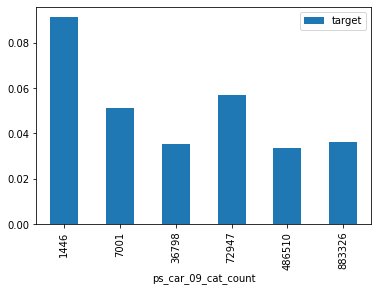

In [24]:
train[["ps_car_09_cat_count", "target"]].groupby("ps_car_09_cat_count").mean().plot.bar()

In [25]:
train[["ps_reg_02", "target"]].corr()

,ps_reg_02,target
ps_reg_02,1.0000,0.0348
target,0.0348,1.0000


<AxesSubplot:xlabel='ps_car_10_cat'>

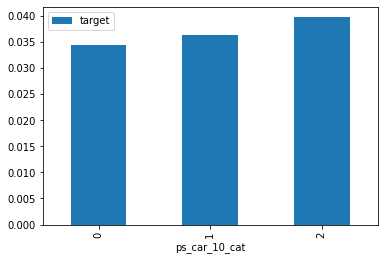

In [26]:
train[["ps_car_10_cat", "target"]].groupby("ps_car_10_cat").mean().plot.bar()

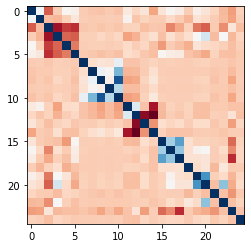

In [27]:
plt.imshow(train[num_features+["target"]].corr(), cmap="RdBu")
#plt.colormaps()

In [28]:
tmp = train[num_features+["target"]].corr()

In [29]:
tmp["target"]

ps_ind_01        0.018570
ps_ind_03        0.008360
ps_ind_06_bin   -0.034017
ps_ind_07_bin    0.034218
ps_ind_08_bin    0.013147
ps_ind_09_bin   -0.008237
ps_ind_10_bin    0.001815
ps_ind_11_bin    0.002028
ps_ind_12_bin    0.007810
ps_ind_13_bin    0.002460
ps_ind_14        0.007443
ps_ind_15       -0.021506
ps_ind_16_bin   -0.027778
ps_ind_17_bin    0.037053
ps_ind_18_bin    0.004555
ps_reg_01        0.022888
ps_reg_02        0.034800
ps_reg_03        0.030888
ps_car_11       -0.001213
ps_car_12        0.038790
ps_car_13        0.053899
ps_car_14       -0.004474
ps_car_15        0.027667
missing         -0.025020
target           1.000000
Name: target, dtype: float64

<AxesSubplot:>

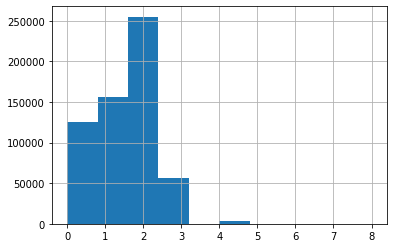

In [30]:
train["missing"].hist()

### Dữ liệu cuối

In [31]:
train_list = [train[num_features+cat_count_features].values,X_cat,]
train_list

[array([[2.00000e+00, 5.00000e+00, 0.00000e+00, ..., 1.47546e+06,
         1.83260e+04, 6.00000e+00],
        [1.00000e+00, 7.00000e+00, 0.00000e+00, ..., 1.47546e+06,
         1.25350e+04, 3.60000e+01],
        [5.00000e+00, 9.00000e+00, 0.00000e+00, ..., 1.47546e+06,
         1.99430e+04, 2.40000e+01],
        ...,
        [1.00000e+00, 1.00000e+01, 1.00000e+00, ..., 1.47546e+06,
         1.31430e+04, 3.82000e+02],
        [5.00000e+00, 3.00000e+00, 0.00000e+00, ..., 1.47546e+06,
         1.84160e+04, 6.50000e+01],
        [0.00000e+00, 8.00000e+00, 1.00000e+00, ..., 1.47546e+06,
         1.17740e+04, 6.99000e+02]]),
 <595212x184 sparse matrix of type '<class 'numpy.float64'>'
 	with 8332968 stored elements in Compressed Sparse Row format>]

In [32]:
num_features+cat_count_features

['ps_ind_01',
 'ps_ind_03',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_14',
 'ps_ind_15',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_11',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15',
 'missing',
 'ps_ind_02_cat_count',
 'ps_ind_04_cat_count',
 'ps_ind_05_cat_count',
 'ps_car_01_cat_count',
 'ps_car_02_cat_count',
 'ps_car_03_cat_count',
 'ps_car_04_cat_count',
 'ps_car_05_cat_count',
 'ps_car_06_cat_count',
 'ps_car_07_cat_count',
 'ps_car_08_cat_count',
 'ps_car_09_cat_count',
 'ps_car_10_cat_count',
 'ps_car_11_cat_count',
 'new_ind_count']

Kế hoạch tiếp theo:
    - Tự code lại feature_engi 
    - Tìm hiểu về xgboost
    - Tìm hiểu về lightGBM và NN

In [33]:
test_list = [test[num_features+cat_count_features].values,X_t_cat,]
test_list

[array([[0.00000e+00, 8.00000e+00, 0.00000e+00, ..., 1.47546e+06,
         2.78000e+04, 1.64000e+02],
        [4.00000e+00, 5.00000e+00, 0.00000e+00, ..., 1.47546e+06,
         6.10620e+04, 8.00000e+00],
        [5.00000e+00, 3.00000e+00, 0.00000e+00, ..., 1.47546e+06,
         1.09570e+04, 5.70000e+01],
        ...,
        [0.00000e+00, 5.00000e+00, 1.00000e+00, ..., 1.47546e+06,
         9.72500e+03, 2.58000e+02],
        [6.00000e+00, 5.00000e+00, 0.00000e+00, ..., 1.47546e+06,
         3.13440e+04, 3.70000e+01],
        [7.00000e+00, 4.00000e+00, 0.00000e+00, ..., 1.47546e+06,
         1.51980e+04, 6.70000e+01]]),
 <892816x184 sparse matrix of type '<class 'numpy.float64'>'
 	with 12499424 stored elements in Compressed Sparse Row format>]

In [34]:
X = ssp.hstack(train_list).tocsr()
X_test = ssp.hstack(test_list).tocsr()

In [35]:
def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]

    # sort rows on prediction column
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:, 0].argsort()][::-1, 0]
    pred_order = arr[arr[:, 1].argsort()][::-1, 0]

    # get Lorenz curves
    L_true = np.cumsum(true_order) * 1. / np.sum(true_order)
    L_pred = np.cumsum(pred_order) * 1. / np.sum(pred_order)
    L_ones = np.linspace(1 / n_samples, 1, n_samples)

    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)

    # normalize to true Gini coefficient
    return G_pred * 1. / G_true

In [36]:
cv_only = True
save_cv = True
full_train = False

In [37]:
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', Gini(labels, preds), True

In [38]:
NFOLDS = 5
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=218)

I. Thiết lập tham số cho LightGBM

In [39]:
learning_rate = 0.1 # Tỉ lệ học 
num_leaves = 15 # Số lượng lá trên toàn cây
min_data_in_leaf = 2000 # Số lượng dữ liệu nhỏ nhất mà một lá có thể có. 
feature_fraction = 0.6 # Dùng để tăng cường 
num_boost_round = 10000 # Số vòng thực hiện tăng cường 
params = {"objective": "binary", # Loại mô hình 
          "boosting_type": "gbdt", # ‘gbdt’, traditional Gradient Boosting Decision Tree.
          "learning_rate": learning_rate,
          "num_leaves": num_leaves,
           "max_bin": 256, # Số bin tối đa
          "feature_fraction": feature_fraction, 
          "verbosity": 0,# 
          "drop_rate": 0.1, # 
          "is_unbalance": False,
          "max_drop": 50,#
          "min_child_samples": 10, #Số lượng dữ liệu tối thiểu cần thiết trong một lá
          "min_child_weight": 150, # Tổng trọng lượng tối thiểu
          "min_split_gain": 0, # Giảm tổn thất tối thiểu để tạo ra một phân vùng sâu hơn trên một nút lá của cây
          "subsample": 0.9 # Tỷ lệ mẫu con 
          }


Link tham khảo:https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [40]:
x_score = []
final_cv_train = np.zeros(len(train_label))
final_cv_pred = np.zeros(len(test_id))
for s in range(16):
    cv_train = np.zeros(len(train_label))
    cv_pred = np.zeros(len(test_id))

    params['seed'] = s

    if cv_only:
        kf = kfold.split(X, train_label)

        best_trees = []
        fold_scores = []

        for i, (train_fold, validate) in enumerate(kf):
            X_train, X_validate, label_train, label_validate = \
                X[train_fold, :], X[validate, :], train_label[train_fold], train_label[validate]
            dtrain = lgbm.Dataset(X_train, label_train)
            dvalid = lgbm.Dataset(X_validate, label_validate, reference=dtrain)
            bst = lgbm.train(params, dtrain, num_boost_round, valid_sets=dvalid, feval=evalerror, verbose_eval=100,
                            early_stopping_rounds=100)
            best_trees.append(bst.best_iteration)
            cv_pred += bst.predict(X_test, num_iteration=bst.best_iteration)
            cv_train[validate] += bst.predict(X_validate)

            score = Gini(label_validate, cv_train[validate])
            print(score) 
            fold_scores.append(score)

        cv_pred /= NFOLDS
        final_cv_train += cv_train
        final_cv_pred += cv_pred

        print("cv score:")
        print (Gini(train_label, cv_train))
        print ("current score:", Gini(train_label, final_cv_train / (s + 1.)), s+1)
        print(fold_scores)
        print(best_trees, np.mean(best_trees))

        x_score.append(Gini(train_label, cv_train))

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.187700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.151575	valid_0's gini: 0.292285
[200]	valid_0's binary_logloss: 0.151472	valid_0's gini: 0.294586
[300]	valid_0's binary_logloss: 0.151548	valid_0's gini: 0.292705
Early stopping, best iteration is:
[200]	valid_0's binary_logloss: 0.151472	valid_0's gini: 0.294586
0.2945863466975217
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.236496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.152123	valid_0's gini: 0.27288
[200]	valid_0's binary_logloss: 0.1

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.205979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.151571	valid_0's gini: 0.292238
[200]	valid_0's binary_logloss: 0.151461	valid_0's gini: 0.295445
[300]	valid_0's binary_logloss: 0.151463	valid_0's gini: 0.295603
Early stopping, best iteration is:
[238]	valid_0's binary_logloss: 0.151458	valid_0's gini: 0.295526
0.29552638162486167
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.356456 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.152052	valid_0's gini: 0.276735
[200]	valid_0's binary_logloss: 0.151941	valid_0's gini: 0.280345
[300]	valid_0's binary_logloss:

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.363903 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.151617	valid_0's gini: 0.291144
[200]	valid_0's binary_logloss: 0.15152	valid_0's gini: 0.293549
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 0.151515	valid_0's gini: 0.293902
0.29390169821275064
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.359576 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.152117	valid_0's gini: 0.273743
[200]	valid_0's binary_logloss: 0.152035	valid_0's gini: 0.276323
[300]	valid_0's binary_logloss: 0.152073	valid_0's gini: 0.276761
Early stopping, best iteration is:
[208]	valid_0's binary_logloss: 0.152015	valid_0's gini: 0.27

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.151575	valid_0's gini: 0.292183
[200]	valid_0's binary_logloss: 0.151489	valid_0's gini: 0.294767
Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.151459	valid_0's gini: 0.295263
0.29526267291076264
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.184721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.15207	valid_0's gini: 0.275252
[200]	valid_0's binary_logloss: 0.152013	valid_0's gini: 0.277725
[300]	valid_0's binary_logloss: 0.

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.229425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.151574	valid_0's gini: 0.292252
[200]	valid_0's binary_logloss: 0.151466	valid_0's gini: 0.294647
[300]	valid_0's binary_logloss: 0.151531	valid_0's gini: 0.293861
Early stopping, best iteration is:
[205]	valid_0's binary_logloss: 0.151458	valid_0's gini: 0.294902
0.2949018978186759
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.184771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.152149	valid_0's gini: 0.274124
[200]	valid_0's binary_logloss: 0.

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.216945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.151582	valid_0's gini: 0.292339
[200]	valid_0's binary_logloss: 0.15152	valid_0's gini: 0.29374
Early stopping, best iteration is:
[198]	valid_0's binary_logloss: 0.151514	valid_0's gini: 0.293908
0.2939079148008999
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.200745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.15208	valid_0's gini: 0.275929
[200]	valid_0's binary_logloss: 0.152015	valid_0's gini: 0.277963
Early stopping, best iteration is:
[1

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.221162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.151595	valid_0's gini: 0.292061
[200]	valid_0's binary_logloss: 0.151529	valid_0's gini: 0.294357
[300]	valid_0's binary_logloss: 0.15157	valid_0's gini: 0.29306
Early stopping, best iteration is:
[203]	valid_0's binary_logloss: 0.151516	valid_0's gini: 0.294581
0.29458068465957576
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.188922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.152153	valid_0's gini: 0.273622
[200]	valid_0's binary_logloss: 0.1

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.165643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.151624	valid_0's gini: 0.29128
[200]	valid_0's binary_logloss: 0.151513	valid_0's gini: 0.294021
[300]	valid_0's binary_logloss: 0.15154	valid_0's gini: 0.293391
Early stopping, best iteration is:
[236]	valid_0's binary_logloss: 0.151485	valid_0's gini: 0.29456
0.2945604033923556
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.195324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.1521	valid_0's gini: 0.275063
[200]	valid_0's binary_logloss: 0.15201

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.151840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.15151	valid_0's gini: 0.294665
[200]	valid_0's binary_logloss: 0.151463	valid_0's gini: 0.295382
Early stopping, best iteration is:
[134]	valid_0's binary_logloss: 0.151456	valid_0's gini: 0.296357
0.2963569973675099
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.192559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.152086	valid_0's gini: 0.275097
[200]	valid_0's binary_logloss: 0.151994	valid_0's gini: 0.278757
Early stopping, best iteration is:


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.172084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.151583	valid_0's gini: 0.291879
[200]	valid_0's binary_logloss: 0.151486	valid_0's gini: 0.294641
Early stopping, best iteration is:
[162]	valid_0's binary_logloss: 0.151473	valid_0's gini: 0.295226
0.29522551001017766
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.231153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.152119	valid_0's gini: 0.273767
[200]	valid_0's binary_logloss: 0.151999	valid_0's gini: 0.278269
Early stopping, best iteration is

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.180221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.151589	valid_0's gini: 0.292492
[200]	valid_0's binary_logloss: 0.151465	valid_0's gini: 0.295767
Early stopping, best iteration is:
[199]	valid_0's binary_logloss: 0.151458	valid_0's gini: 0.295932
0.29593235255852257
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.211540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.152082	valid_0's gini: 0.275056
[200]	valid_0's binary_logloss: 0.151999	valid_0's gini: 0.27844
[300]	valid_0's binary_logloss: 0.

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.331679 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.151533	valid_0's gini: 0.293456
[200]	valid_0's binary_logloss: 0.15146	valid_0's gini: 0.295603
Early stopping, best iteration is:
[185]	valid_0's binary_logloss: 0.15146	valid_0's gini: 0.295845
0.2958448863286207
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.223965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.152127	valid_0's gini: 0.27526
[200]	valid_0's binary_logloss: 0.152094	valid_0's gini: 0.275812
[300]	valid_0's binary_logloss: 0.152115	valid_0's gini: 0.276467
Early stopping, best iteration is:


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.174092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.151583	valid_0's gini: 0.29256
[200]	valid_0's binary_logloss: 0.151488	valid_0's gini: 0.295679
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 0.151474	valid_0's gini: 0.295961
0.29596144233332095
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.167665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.152186	valid_0's gini: 0.27254
[200]	valid_0's binary_logloss: 0.152123	valid_0's gini: 0.274474
[300]	valid_0's binary_logloss: 0.1

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.346632 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.151537	valid_0's gini: 0.293457
[200]	valid_0's binary_logloss: 0.151457	valid_0's gini: 0.295291
Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 0.151449	valid_0's gini: 0.295455
0.2954550978128508
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.215017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.152144	valid_0's gini: 0.272779
[200]	valid_0's binary_logloss: 0.152089	valid_0's gini: 0.274936
[300]	valid_0's binary_logloss: 0.152119	valid_0's gini: 0.275333
Early stopping, best iteration i

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.204749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.151573	valid_0's gini: 0.292232
[200]	valid_0's binary_logloss: 0.151489	valid_0's gini: 0.294596
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.151479	valid_0's gini: 0.294961
0.29496092526749645
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.361740 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.152171	valid_0's gini: 0.271767
[200]	valid_0's binary_logloss: 0.152114	valid_0's gini: 0.274211
Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 0.152059	valid_0's gini: 0.275

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.165614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.151573	valid_0's gini: 0.292146
[200]	valid_0's binary_logloss: 0.151515	valid_0's gini: 0.294024
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 0.151502	valid_0's gini: 0.294194
0.29419368095026177
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.181143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.152047	valid_0's gini: 0.27558
[200]	valid_0's binary_logloss: 0.151937	valid_0's gini: 0.279258
[300]	valid_0's binary_logloss: 0.

In [ ]:
#lưu dữ liệu vào dataframe

In [41]:
print(x_score)
pd.DataFrame({'id': test_id, 'target': final_cv_pred / 16.}).to_csv('./model/lgbm3_pred_avg.csv', index=False)
pd.DataFrame({'id': train_id, 'target': final_cv_train / 16.}).to_csv('./model/lgbm3_cv_avg.csv', index=False)

[0.28581087287246515, 0.28612703231439995, 0.28523677934240615, 0.2867214013659066, 0.28570773588756787, 0.2862086579536886, 0.2862973628978743, 0.28701986704651966, 0.28641085376805125, 0.28608409208647545, 0.287066334227867, 0.2860178438419425, 0.2857536785509344, 0.28594513163263857, 0.2858514964123292, 0.2860899794511859]
